## Time Series Exercises - ACM Summer School 2018

We assume that Python 3 + Anaconda are installed; furthermore the following packages are required:

* numpy
* pandas
* statsmodels
* matplotlib
* scikit-learn
* jupyter

### Troubleshooting

1. **I don't have Anaconda/Python3**. We highly recommend installing Anaconda. See installation instructions [here](https://conda.io/docs/user-guide/install/index.html). You're welcome to use Python without Anaconda, but you're on your own if you do!

2. **I don't have the above packages / I'm not sure I have the above packages**. It's often sensible to set up a virtual environment for new package requirements. 
    * ** I know what a virtual environment is, and no, I don't want a new one**. Sure, activate an existing virtual environment and install the above packages using `conda install <package name(s)>`.
    * ** I don't know what a virtual environment is, or I want to create a new one**. The following command should generate an environment called `timeseries` with the required packages: 
    
 ```
 conda create -n timeseries python=3 matplotlib numpy pandas statsmodels scikit-learn jupyter
 ```

3. ** How do I run the notebook?**
Let's call the virtual environment in step 2 `<env name>`. 
Jupyter can then be launched from either:
    * **Anaconda Navigator**: please select `<env name>` from the dropdown menu at the top ("applications on..." or similar) _first_, and then launch jupyter notebook; or
    * **Command line**: by activating the environment and then launching jupyter. This can be achieved with the following two lines at the command line:
```shell
conda activate <env name>
jupyter notebook
```

 The notebook server should appear in your browser. Simply navigate to the (this) notebook file and open it.

--------------

Please run the following cell and continue with the exercises below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import warnings
# statsmodels: depending on version, may give FutureWarning due to deprecation of old pandas
# API and numpy datatype methods. Nothing to worry about here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)  
    from statsmodels.tsa.arima_process import ArmaProcess
    from statsmodels.tsa.arima_model import ARMA

------
## Instructions
<br>
You'll submit a document (either text or pdf) with the results of the marked exercises. No code needs to be submitted, so you can write whatever you like in the notebook. Some questions require free text answers, others require numeric answers. No question needs an answer longer than a paragraph, so please spend the time exploring and thinking rather than writing.

When you've finished your answers, please <span style="color:red">**[SUBMIT/DO SOMETHING UNKNOWN]**</span>
   
The format of this notebook is as follows:

* **<span style="color:blue">Useful Statsmodels Classes</span>**
    * We'll be working with some python classes that may be unfamiliar.
* **<span style="color:blue">Warmup: AR Processes</span>**
    * This is to gain familiarity with AR Processes and/or using the python implementations before working on real data. This may be skipped by those who have the necessary background.
* **<span style="color:blue">Introducing the MHEALTH dataset</span>**
    * This is the real-world dataset that we'll be using in our exercises. A brief introduction is given here.
* **<span style="color:blue">Exercise 1: Modelling and predicting sequential data.</span>**
    * This is a chance to use your knowledge of AR processes in practice.
* **<span style="color:blue">Exercise 2: Time Series Classification.</span>**
    * Here we'll cover a method for classifying sections of a time series.
---------

##  Useful Statsmodels Classes: 

The time series objects we'll be using come from the `statsmodels` package. See the imports above. Below is a brief introduction.

#### <span style="color:blue"> ArmaProcess </span>
The ArmaProcess class calculates a number of properties of <span style="color:blue">**theoretical**</span> ARMA models as well as generating samples.

The ArmaProcess class covers all orders of AR, MA and ARMA models. Specifying an AR process is a little convoluted, so please be patient. First, the 'zero-order' coefficient (informally, the 'scale') must be specified, which we choose here as `1`. Then the AR coefficients are specified as their negative (following the signal processing or lag polynomial convention). As an example, an AR(1) process with $\phi_1 = 0.5$ would be specified with coefficients `[1, -0.5]`. We must also specify the MA part of the process, which if null still requires the 'zero-order' coefficient `1` (the noise standard deviation).

```python
ArmaProcess([1, -0.5], [1])
```

See `?ArmaProcess` for further documentation. If the details do not interest you, simply remember that the `1`s must be specified as above, and all AR coefficients are negated and appended to the first list.

#### <span style="color:blue"> ARMA </span>
The ARMA class is concerned with more <span style="color:blue">**practical**</span> aspects of ARMA models: fitting and forecasting. This class has a more intuitive interface: `ARMA(<data to fit>, order=(ar_order, ma_order))`. This syntax only instantiates the class, the method `.fit()` calculates the parameters, and `.summary()` gives a printout of useful model fit quantities. Finally `.predict(start=..., end=...)` calculates in-sample 1-step predictions where relevant in the range specified, and forecasts out of sample if `end` is larger than the length of the data. `.plot_predict()` is an analogous function which outputs a *plot* of the predictions. Relevant methods will be highlighted again in what follows.

---------------
## Warmup: AR processes [0 marks]
The aim of these guided exercises is to gain familiarity with AR processes and the relevant tools available in python. This is not a graded part of the exercise, and those familiar with AR models in python may skip this section if desired. We encourage you to spend less than 20 minutes on this section.

### 0 (a): Examples of AR(1) processes

Samples of AR processes may be obtained using the `.generate_sample(nsample=...)` method of the `ArmaProcess` class. Generate samples for different values of $\phi$. What characteristics do the different values give? (Note that $|\phi| < 1$ is required for stationarity). Example code is given below to get you started:

```python
phi = ___
ar_process = ArmaProcess([1, -phi], [1])
ar_sample = ar_process.___
plt.plot(ar_sample)
```

### 0 (b): Autocorrelation and the ACF
By considering known properties of AR processes, we can build tools to diagnose their order.

<span style="color:blue">**Autocorrelation**</span>. Autocorrelation is defined as the correlation between a data series and a lagged copy of itself. We may first be interested in a *lag 1* autocorrelation, that is for a time series $\mathbf y$ of length $T$:

$$
\rho(1) = \text{corr}\,(\mathbf y_{2:T}, \mathbf y_{1:(T-1)})
$$

Draw a scatter plot comparing values at $t+1$ vs. $t$ using `lag_plot` from `pandas` (below). The AR sample should be converted to a pandas `pd.Series` type first, and the correlation values may be calculated with the method `.autocorr()`.

In [2]:
from pandas.plotting import lag_plot

<span style="color:blue">**Autocorrelation Function (ACF)**</span>. Now we can apply a similar idea to different lags other than 1. We define $\rho(\tau)$ to be the autocorrelation at lag $\tau$. We can use the `statsmodels` implementation and plot the autocorrelations for integral lags using the `plot_acf` function. Hint: be sure to include the `lags` argument in `plot_acf(<data>, lags=<max. lags>)`, otherwise your plot may be unhelpful for large $T$. You may wish to terminate the function with a semicolon (;) if jupyter prints the plot twice.

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
?plot_acf

<span style="color:blue">**Partial Autocorrelation Function (PACF)**</span>. Notice that even though we created an autoregressive model of order 1, autocorrelation exists across a much larger range of lags $\tau$. *Quick question: what is the theoretical value of ACF($\tau$) for an AR(1) process with parameter $\phi$?*. The partial autocorrelation function iteratively subtracts the influence of previous autoregressive coefficients, so that each PACF($\tau$) is only the *incremental* or *remaining* autocorrelation at lag $\tau$.

We can plot this using the `statsmodel` function `plot_pacf()`. The arguments are the same as before. Notice that this approximately recovers the AR parameters used to generate the data.

### 0 (c): Fitting an AR process
For the purposes of fitting the model, the `ARMA` class introduced in Section 0 will be useful. Using one of the time series generated above, instantiate the model using:

```python
model = ARMA(<data>, order=(1,0))
```

where the order argument specifies an AR(1) model (the *MA* component has order 0). The model can then be fit using:

```python
fitted = model.fit()
```

Take a look at the summary of the fitted model using method `.summary()`. Some useful quantities shown here are the AR coefficient(s), including the mean, and their confidence intervals, and <font color="blue">**AIC**</font>/<font color="blue">**BIC**</font> values for __[model selection](https://en.wikipedia.org/wiki/Model_selection)__.

We can then perform in sample 1-step-ahead prediction using `predict(start=..., end=...)`, where start/end indices should specify a range inside the series. Forecasting can be performed by specifying the `end` beyond the range of the time series. The <font color="blue">**predictions**</font> (and confidence intervals) can be plotted using the `.plot_predict(start=..., end=...);` method. Notice the shape of the confidence intervals when forecasting.

### 0 (d):  AR - Bonus
<font color='red'> (skip this section if running low on time) </font><br>
This is your chance to explore the different parameters. Investigate what sample AR(2) or AR(3) processes look like. What happens to the ACF/PACF? Look at the model fits: particularly when the model order is mis-specified. Think about which situations definitely require higher order AR processes.

Note that unless the process is stationary or at least has unit root, the generated samples will diverge quickly. To test your coefficients for stationarity, consider the following example:

```python
ar_process = ArmaProcess([1, -0.7, -0.25, 0.3], [1])
roots = np.absolute(np.roots(list(reversed([1, -0.7, -0.25, 0.3]))))
```
Stationarity requires all `roots` to have magnitude above 1.

### 0 (e): Smoothing
The relevant information in a time series may be in a slowly moving underlying component which is corrupted by noise. There are a number of ways to de-noise a time series; we consider one particularly simple form here, (weighted) moving or <span style="color:blue">**rolling averages**</span>. (We call them 'rolling averages' here in order to emphasise the different perspective from the Moving Average process in the ARMA context.) One may think of these as a form of low-pass filter in the signal processing context.

`pandas` has a number of 'window functions' (weights) that can be applied for a rolling average, see `?pd.Series.rolling` alongside descriptions on [Wikipedia](https://en.wikipedia.org/wiki/Window_function) if interested. To apply the rolling average, ensure that the data type is of type `pd.Series` and use the method `.rolling(window_size, win_type=...).mean()` to perform the averaging. 

The below generates a corrupted sequence, with the decomposition into a smooth underlying component (shown as blue) and a noise process (shown as orange). Smooth the corrupted signal `seq_corrupt` using a rolling average. Experiment with different parameters.

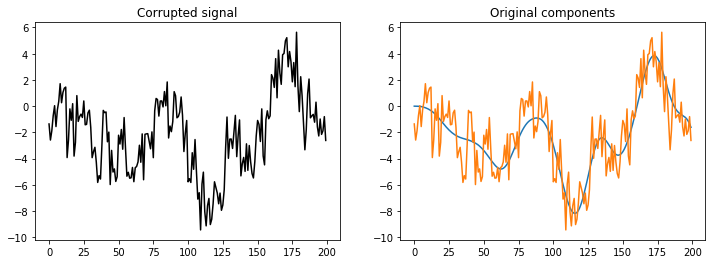

In [24]:
ar_noise_param = 0.3
noise_scale = 1.5
nsmp = 200
seq_smooth = pd.Series(ArmaProcess([1], np.blackman(50)).generate_sample(nsample=nsmp))
seq_noise = pd.Series(noise_scale*ArmaProcess([1, -ar_noise_param], [1]).generate_sample(nsample=nsmp))
seq_corrupt = seq_smooth + seq_noise

# Plot the signals
plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax.plot(seq_corrupt, color='k')
ax.set_title('Corrupted signal')
ax = plt.subplot(1,2,2)
ax.plot(seq_smooth.values)
ax.plot((seq_noise+seq_smooth).values)
ax.set_title('Original components');

### 0 (f): Smoothing - Bonus
<font color='red'> (skip this section if running low on time) </font><br>
Plot your reconstruction alongside the original `seq_smooth` signal. You may need to add the argument `center=True` into the `pd.Series.rolling` method. How closely does it fit? Compare with different window functions and parameters. Experiment with different values of `noise_scale` and the `ar_noise_param` in the data generation above. How do different values of these parameters affect the reconstruction?

--------------

-------------
## MHEALTH Activity Recognition Dataset
The MHEALTH dataset is a recording of 10 subjects undergoing 12 different activities with various wearable sensors. The full dataset contains 1 matrix per subject, indexed by time (order of 100,000 timepoints) and sensor. Each point in time is also given an activity classification. For these exercises, we are interested in a reduced scope: only 5 measurement channels of the first individual. The measurements are also restricted to 4 activities: standing, walking, running, climbing stairs. The activities and channels are coded as:

<table>
	<td>
        <div align="center"> <strong>Activity Codes </strong></div>
		<table border="1" class="dataframe">
		  <thead>
		    <tr style="text-align: right;">
		      <th>Activity</th>
		      <th>Description</th>
		    </tr>
		  </thead>
		  <tbody>
		    <tr>
		      <td>1</td>
		      <td>Standing</td>
		    </tr>
		    <tr>
		      <td>2</td>
		      <td>Walking</td>
		    </tr>
		    <tr>
		      <td>3</td>
		      <td>Climbing Stairs</td>
		    </tr>
		    <tr>
		      <td>4</td>
		      <td>Running</td>
		    </tr>
		  </tbody>
		</table>
	</td>
    <td>
		<table border="10" cellpadding="40">
            <tr> 
                <td colspan="30" height="20"></td> 
                <td colspan="30" height="20"></td>
                <td colspan="300" height="200"></td>
                <td colspan="300" height="200"></td>
                <td colspan="300" height="200"></td>
            </tr> 
		</table>
	</td>
	<td>
        <div align="center"> <strong> Channels </strong></div>
		<table border="1" class="dataframe">
		  <thead>
		    <tr style="text-align: right;">
		      <th>Channel</th>
		      <th>Description</th>
		    </tr>
		  </thead>
		  <tbody>
		    <tr>
		      <td>1</td>
		      <td>Chest Acceleration (X)</td>
		    </tr>
		    <tr>
		      <td>2</td>
		      <td>Chest Acceleration (Y)</td>
		    </tr>
		    <tr>
		      <td>3</td>
		      <td>ECG (Lead 1)</td>
		    </tr>
		    <tr>
		      <td>4</td>
		      <td>Left ankle accel. (X)</td>
		    </tr>
		    <tr>
		      <td>5</td>
		      <td>Right arm accel. (Y)</td>
		    </tr>
		  </tbody>
		</table>
	</td>
</table>

Here X,Y refer to the co-ordinate direction of the measurement. The full dataset can be explored and downloaded from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset#) if desired. The different classes are each performed in a single block in the original data. We have spliced the activities such that they are now performed in multiple blocks, but note that the ECG is not modified, so the subject has a rather magical heart.

In [ ]:
import athenstsutil
mhdata = athenstsutil.mhealth_data()

After loading the above python file, the `mhealth_data` class should be available to you. This will load the time series data into memory and provide a number of useful access utilities outlined below.

```python
mhdata.data                # observation DataFrame for all time and channels

mhdata.annotation(classnm) # boolean Series for patient i indicating when the activity
                           # is of requested class name (or id).

mhdata.annotations()       # A Series with the classification id of all timepoints.
                           # Can use option 'as_one_hot' to return a 0/1 DataFrame
                           # with each column as a separate class.

mhdata.intervals(classnm)  # a mx2 matrix of (start,end) index pairs corresponding to
                           # the class name (or id) given.

mhdata.chunks(classnm)     # a list of observation DataFrames each corresponding to the
                           # classification requested.
```

An example of its use is shown below in plotting the full dataset, and then a subset of all sections of class 3 (Climbing Stairs).

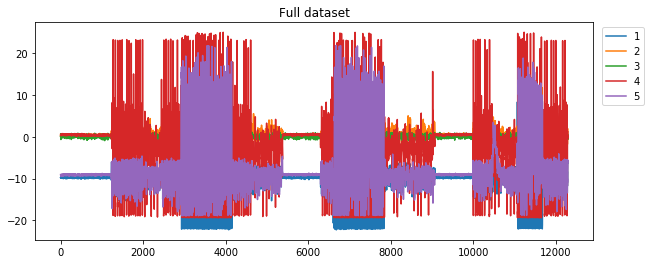

In [21]:
# Plot full dataset
ax = mhdata.data.plot()
ax.legend(bbox_to_anchor=(1.1, 1)) # move legend outside
plt.gcf().set_size_inches(10,4)    # resize plot
plt.title('Full dataset');         # title

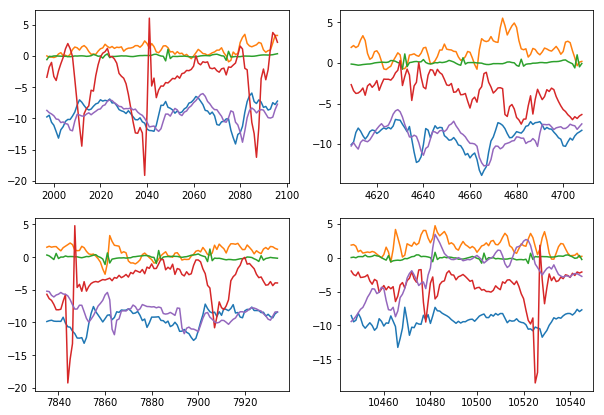

In [22]:
# Plot sections of a given activity class
classid = 3
f, axs = plt.subplots(*athenstsutil._splt_gridsize(len(mhdata.intervals(classid))));
[ax.plot(y.head(100)) for ax, y in zip(axs.reshape(-1), mhdata.chunks(classid))];
f.set_size_inches(10,7)

--------------------
## Exercise 1: Modelling Sequential Data
We will attempt to model the subject's stair climbing dynamics using an autoregressive process. 

* **(a) Visualise the data for each channel. **
  * ** Does the data look amenable to an AR model?  **
  * ** Are there any features that may be difficult to capture using only an AR model? **
  
 ** [2 marks] **

The following `pandas.DataFrame` commands may be useful for visualisation:
* `.head(n)` selects the first `n` rows of the data.
* `.loc[start:end]` selects rows between `start` and `end` indices. Note the **square** brackets.
* While columns can be indexed directly by name, array indexing can be performed with `.iloc[..., ...]`
* `.plot(figsize=(10,8), subplots=True)` plots the columns in separate subplots, and resizes the output.

below a training and test set is defined, where we increasingly allow the model to see more data and forecast the next 60 steps ahead.

In [ ]:
# use the third section of 'Climbing Stairs' data: 
stairs_data = mhdata.chunks('Climbing Stairs')[2]

--------------
* ** (b) For channel 1 of the same data, plot the ACF/PACF introduced in 0(b). **
    * ** What order does it suggest if modelling with an AR model? **
    * ** How did you arrive at this answer? Are you confident? **
    
   ** [2 marks] ** (You may assume that the data series is stationary.)

------------------
* **(c) Fit an appropriate AR order to channel 1 of the data using the ARMA function introduced in 0(c). **
    * ** What happens to the prediction as it is forecast out of sample? **
    * ** What features of the data does the model describe well? **
    * ** What features of the data does the model apparently miss? **

 ** [3 marks] **
<font color='red'>N.b. the following argument may yield substantial performance improvements when fitting: `ARMA(...).fit(method='css')`, particularly for large orders. </font>

-----------------
The `ARMA_plot_predictions` and `ARMA_mse_predictions` from our utilities package will plot and calculate the predictive MSE for a specified order for the above data. (The forecasts are made at 9 different locations and MSE calculated out of sample, the MSE predictive window is 60; use argument `step_ahead=...` for a different window size.)

* **(d) For channel 1, trial different AR orders and investigate their fits using these functions.**
  * ** Under what conditions are AR models likely to perform much better than a constant forecast? ** 
  * ** According to the test MSE, what is the best order of the AR($p$) model for $p \in \{0,1,2,\ldots,20\}$? Is this different to your answer in 1(a)? Discuss.**
  
 ** [2 marks] **

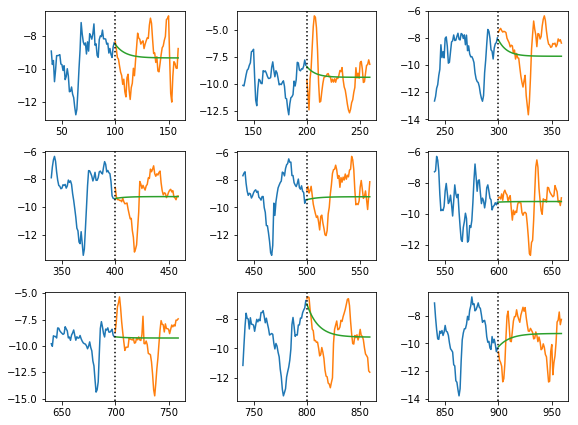

In [9]:
from athenstsutil import ARMA_plot_predictions, ARMA_mse_predictions
ar_order = 1
channel = 1
athenstsutil.ARMA_plot_predictions((ar_order, 0), channel=channel)

------------
* **(e) Alternatives: **<br>
    **(Assume no covariates / further information are available except the historical time series itself.**)
  * **Suggest features of a time series which may be forecasted better than an AR model.**
  * **Suggest an alternative model which would perform better in your chosen situation.**
  
  ** [ 2 marks] **

------------------
## Exercise 2: Classifying Time Series
We now switch from time series prediction to classification. One can use `.training()` of `mhdata` to extract the first 70% of the dataset and one-hot encodings for the class as below, and similarly `.test()` corresponds to the last 30%.

We will look at building a sliding window classifier: first, to extract features in a sliding window, and then applying different classifiers.

* **(a) Transform the window into sliding window format **
Transform the data to have sliding windows of length 6. Let the design matrix $X$ be of size $N \times 5$. Split the matrix into its 5 columns, and with each column $i$, create a new matrix $M_i$ of size $(N-5) \times 20$, where each row is a rolling window of length 6. Specifically, the matrix should be of the form:

$$
\begin{pmatrix} x_{1} & x_{2} & \dots & x_{6} \\
x_{2} & x_{3} & \dots & x_{7} \\
x_{3} & x_{4} & \dots & x_{8} \\
\ldots & \ldots & \ldots & \ldots 
\end{pmatrix}
$$

for each channel (where channel index is omitted in the above for clarity). The result chan be checked with `athenstsutil.check_training_data(X1, X2, X3, X4, X5)`, where X2 is for example the matrix for the second channel. **If correct, the function will give a codephrase for the report.**

  ** [ 5 marks] **

In [ ]:
X, y = mhdata.training()
...

In [ ]:
athenstsutil.check_training_data(...)

---------

Now load in the transformed test set too (we've done this for you). Each of $X_{train}$ and $X_{test}$ consists of a list of DataFrames, one per channel. 

* **(b) Extract some features for each window across all channels by adding to the function `derive_features`**

It is recommended that you start with a small number of features, for example a rolling mean. More features can easily be added later. For speed, we recommend applying the same transformations to each channel.

In [ ]:
Xtrain, ytrain, Xtest, ytest = athenstsutil.get_sliding_training_test_data(as_lists=True)

In [ ]:
# This function will act row-wise on each DataFrame (on 1D vectors)
def derive_features(x):
    feature_vector = np.mean(x)   # effectively a rolling mean
    ...
    # ----------------------------------------
    # Fill in more feature extraction here
    # e.g. feature_vector.append(x[0])
    # ----------------------------------------
    ...
    return np.atleast_1d(feature_vector)


The following code will perform the feature extraction defined above (if executes properly), and construct matrices for use by Classifiers

In [ ]:
print("Extracting features for *training* set...")
train_features = []
for i in range(5):
    train_features.append(np.stack([derive_features(x) for x in Xtrain[i]]))

print("Extracting features for *test* set...")
test_features = []
for i in range(5):
    test_features.append(np.stack([derive_features(x) for x in Xtest[i]]))
    
pd_train = pd.DataFrame(np.hstack(train_features))
pd_test = pd.DataFrame(np.hstack(test_features))

---------------------------------

* **(c) Using the multivariate feature data in `pd_train` and `pd_test`, perform classification using Logistic Regression. Report the test set accuracy and precision/recall. **

You may want to iterate questions (b) and (c) to improve accuracy. If desired, experiment with L1/L2 regularisation.

** [10 marks] **

In [ ]:
from sklearn.linear_model import LogisticRegression

----------------

* **(d) [Bonus] We are currently performing classification per window. How might we alter our methodology in order to estimate the _interval_ of each activity?**

(text only)

----------

* **(e) [Bonus] Try different classifiers (e.g. SVM, Random Forests, RNNs (if time!), ...). What performance improvements can be found? **